1. Write a program which resotres a degraded image using direct inverse filtering.

2. Write a prgraom for implementing Wiener filtering for linear img restoration using  

    a. a constant ratio  
    b. auto correaltion function.

3. Write a program to convert an rgb color space to HSI. Display the hue img, saturation img, and the intensity img.

4. Write a program to histogram equalize the intensity component of a color img, and get a new HSI img. Conver the new HSI img to rgb.

5. Write a program to detect the line segements in a binary img using Hough transform.

6. Comsider an image composed of small, non overlapping blobs. Write a program to segment the blobs based on thresholding.

In [30]:
import requests

image_url = "https://i.ytimg.com/vi/vEYsdh6uiS4/maxresdefault.jpg"
response = requests.get(image_url)

if response.status_code == 200:
    with open("image1.png", 'wb') as f:
        f.write(response.content)
    print("Image downloaded successfully as image1.png")
else:
    print(f"Failed to download image. Status code: {response.status_code}")

Image downloaded successfully as image1.png


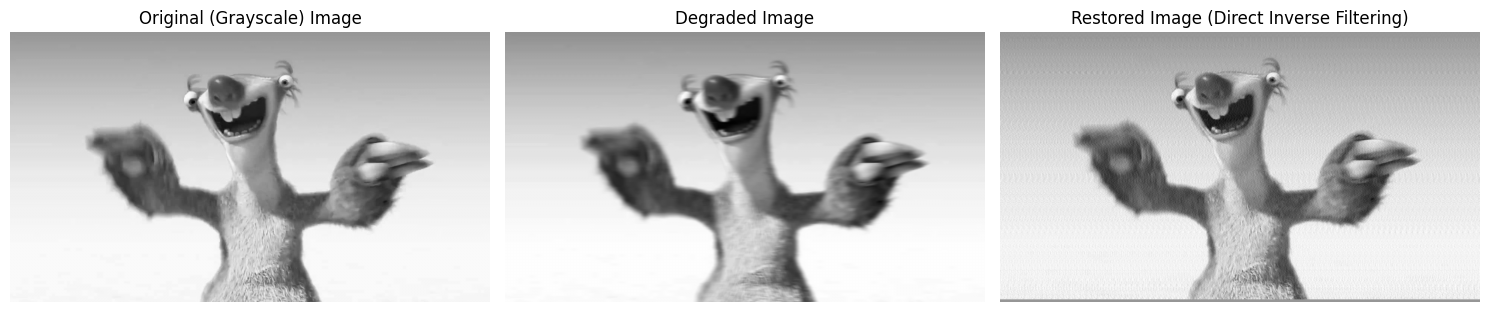

In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('image1.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel_size = 15
kernel = np.zeros((kernel_size, kernel_size))
kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
kernel = kernel / kernel_size

degraded_img = cv2.filter2D(gray_img, -1, kernel)

gray_img_float = np.float32(gray_img)
degraded_img_float = np.float32(degraded_img)
kernel_float = np.float32(kernel)

kernel_padded = np.zeros(gray_img_float.shape, dtype=np.float32)
kernel_padded[:kernel.shape[0], :kernel.shape[1]] = kernel_float

fft_gray = cv2.dft(gray_img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
fft_degraded = cv2.dft(degraded_img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
fft_kernel = cv2.dft(kernel_padded, flags=cv2.DFT_COMPLEX_OUTPUT)

epsilon = 1e-8
fft_restored = np.zeros_like(fft_degraded)
fft_restored[:,:,0] = (fft_degraded[:,:,0] * fft_kernel[:,:,0] + fft_degraded[:,:,1] * fft_kernel[:,:,1]) / (fft_kernel[:,:,0]**2 + fft_kernel[:,:,1]**2 + epsilon)
fft_restored[:,:,1] = (fft_degraded[:,:,1] * fft_kernel[:,:,0] - fft_degraded[:,:,0] * fft_kernel[:,:,1]) / (fft_kernel[:,:,0]**2 + fft_kernel[:,:,1]**2 + epsilon)


restored_img_float = cv2.idft(fft_restored, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)

restored_img = np.uint8(np.clip(restored_img_float, 0, 255))

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original (Grayscale) Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(degraded_img, cmap='gray')
plt.title('Degraded Image')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(restored_img, cmap='gray')
plt.title('Restored Image (Direct Inverse Filtering)')
plt.axis('off')

plt.tight_layout()
plt.show()

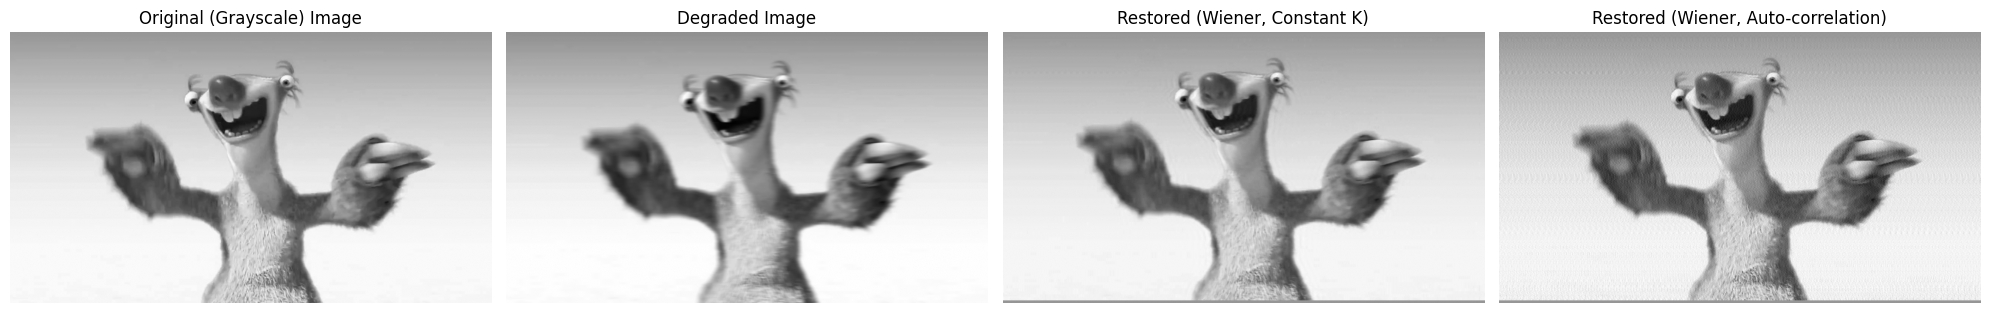

In [32]:
img = cv2.imread('image1.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

kernel_size = 15
kernel = np.zeros((kernel_size, kernel_size))
kernel[int((kernel_size - 1) / 2), :] = np.ones(kernel_size)
kernel = kernel / kernel_size

degraded_img = cv2.filter2D(gray_img, -1, kernel)

gray_img_float = np.float32(gray_img)
degraded_img_float = np.float32(degraded_img)
kernel_float = np.float32(kernel)

kernel_padded = np.zeros(gray_img_float.shape, dtype=np.float32)
kernel_padded[:kernel.shape[0], :kernel.shape[1]] = kernel_float

fft_gray = cv2.dft(gray_img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
fft_degraded = cv2.dft(degraded_img_float, flags=cv2.DFT_COMPLEX_OUTPUT)
fft_kernel = cv2.dft(kernel_padded, flags=cv2.DFT_COMPLEX_OUTPUT)

K = 0.01
fft_kernel_conj = fft_kernel.copy()
fft_kernel_conj[:,:,1] = -fft_kernel_conj[:,:,1]

magnitude_sq = cv2.magnitude(fft_kernel[:,:,0], fft_kernel[:,:,1])**2
denominator_k = magnitude_sq + K

wiener_filter_k = np.zeros_like(fft_kernel)
wiener_filter_k[:,:,0] = (fft_kernel_conj[:,:,0] * denominator_k) / (denominator_k**2)
wiener_filter_k[:,:,1] = (fft_kernel_conj[:,:,1] * denominator_k) / (denominator_k**2)
wiener_filter_k[:,:,0] = fft_kernel_conj[:,:,0] / denominator_k
wiener_filter_k[:,:,1] = fft_kernel_conj[:,:,1] / denominator_k


fft_restored_k = cv2.mulSpectrums(fft_degraded, wiener_filter_k, flags=0)

restored_img_k_float = cv2.idft(fft_restored_k, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
restored_img_k = np.uint8(np.clip(restored_img_k_float, 0, 255))

psd_original = cv2.magnitude(fft_gray[:,:,0], fft_gray[:,:,1])**2

noise_power = 0.01

epsilon = 1e-8
denominator_ac = cv2.magnitude(fft_kernel[:,:,0], fft_kernel[:,:,1])**2 + noise_power / (psd_original + epsilon)

wiener_filter_ac = np.zeros_like(fft_kernel)
wiener_filter_ac[:,:,0] = (fft_kernel_conj[:,:,0] * denominator_ac) / (denominator_ac**2)
wiener_filter_ac[:,:,1] = (fft_kernel_conj[:,:,1] * denominator_ac) / (denominator_ac**2)
wiener_filter_ac[:,:,0] = fft_kernel_conj[:,:,0] / denominator_ac
wiener_filter_ac[:,:,1] = fft_kernel_conj[:,:,1] / denominator_ac


fft_restored_ac = cv2.mulSpectrums(fft_degraded, wiener_filter_ac, flags=0)

restored_img_ac_float = cv2.idft(fft_restored_ac, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
restored_img_ac = np.uint8(np.clip(restored_img_ac_float, 0, 255))


plt.figure(figsize=(20, 5))

plt.subplot(1, 4, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original (Grayscale) Image')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(degraded_img, cmap='gray')
plt.title('Degraded Image')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(restored_img_k, cmap='gray')
plt.title('Restored (Wiener, Constant K)')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(restored_img_ac, cmap='gray')
plt.title('Restored (Wiener, Auto-correlation)')
plt.axis('off')


plt.tight_layout()
plt.show()

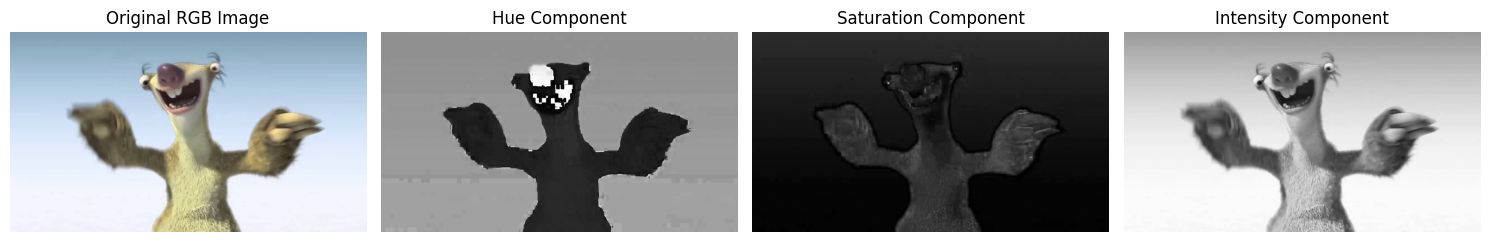

In [33]:
rgb_img = cv2.imread('image1.png')

bgr_float = rgb_img.astype(np.float32) / 255.0
b, g, r = cv2.split(bgr_float)

intensity = (r + g + b) / 3.0

min_rgb = np.minimum(np.minimum(r, g), b)
sum_rgb = r + g + b

saturation = 1.0 - (3.0 * min_rgb / (sum_rgb + 1e-8))
saturation[sum_rgb < 1e-8] = 0

numerator_h = ((r - g) + (r - b)) / 2.0
denominator_h = np.sqrt((r - g)**2 + (r - b) * (g - b))

argument_h = np.clip(numerator_h / (denominator_h + 1e-8), -1.0, 1.0)

hue = np.arccos(argument_h)
hue = np.degrees(hue)

hue[b > g] = 360 - hue[b > g]

hue = hue / 360.0

plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)

plt.imshow(cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB))
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 4, 2)

plt.imshow(hue, cmap='gray')
plt.title('Hue Component')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(saturation, cmap='gray')
plt.title('Saturation Component')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(intensity, cmap='gray')
plt.title('Intensity Component')
plt.axis('off')

plt.tight_layout()
plt.show()


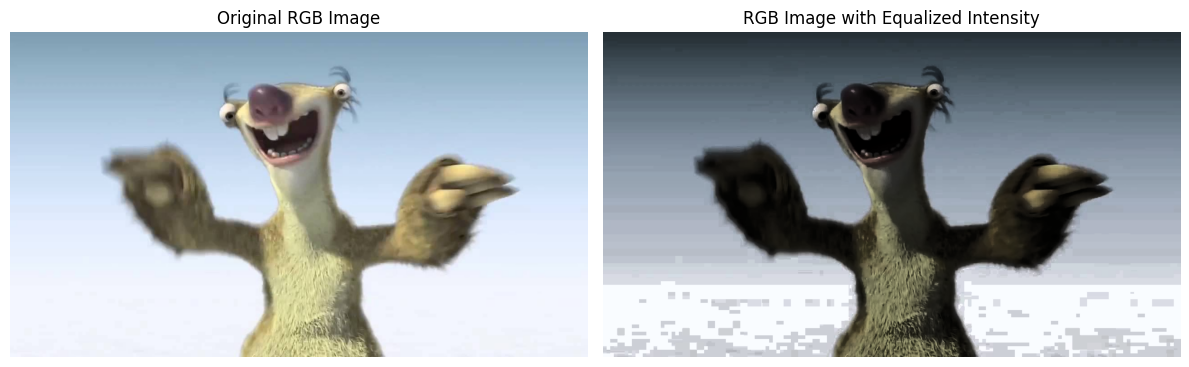

In [34]:
bgr_float = rgb_img.astype(np.float32) / 255.0
b, g, r = cv2.split(bgr_float)

intensity = (r + g + b) / 3.0

min_rgb = np.minimum(np.minimum(r, g), b)
sum_rgb = r + g + b
saturation = 1.0 - (3.0 * min_rgb / (sum_rgb + 1e-8))
saturation[sum_rgb < 1e-8] = 0

numerator_h = ((r - g) + (r - b)) / 2.0
denominator_h = np.sqrt((r - g)**2 + (r - b) * (g - b))
argument_h = np.clip(numerator_h / (denominator_h + 1e-8), -1.0, 1.0)
hue = np.arccos(argument_h)
hue = np.degrees(hue)
hue[b > g] = 360 - hue[b > g]
hue = hue / 360.0

intensity_uint8 = np.uint8(intensity * 255)
equalized_intensity_uint8 = cv2.equalizeHist(intensity_uint8)

equalized_intensity = equalized_intensity_uint8.astype(np.float32) / 255.0

new_hue = hue
new_saturation = saturation
new_intensity = equalized_intensity

# Formulas for RGB from HSI (H in [0, 360), S and I in [0, 1]):

# Case 1: 0 <= H < 120 degrees
# B = I * (1 - S)
# R = I * (1 + S * cos(H) / cos(60 - H))
# G = 3 * I - (R + B)

# Case 2: 120 <= H < 240 degrees
# H = H - 120
# R = I * (1 - S)
# G = I * (1 + S * cos(H) / cos(60 - H))
# B = 3 * I - (R + G)

# Case 3: 240 <= H < 360 degrees
# H = H - 240
# G = I * (1 - S)
# B = I * (1 + S * cos(H) / cos(60 - H))
# R = 3 * I - (G + B)

new_hue_deg = new_hue * 360.0

new_b = np.zeros_like(new_intensity)
new_g = np.zeros_like(new_intensity)
new_r = np.zeros_like(new_intensity)

# Case 1: 0 <= H < 120
idx1 = (new_hue_deg >= 0) & (new_hue_deg < 120)
H1 = new_hue_deg[idx1]
S1 = new_saturation[idx1]
I1 = new_intensity[idx1]

H1_rad = np.radians(H1)
new_b[idx1] = I1 * (1 - S1)
new_r[idx1] = I1 * (1 + S1 * np.cos(H1_rad) / (np.cos(np.radians(60 - H1)) + 1e-8))
new_g[idx1] = 3 * I1 - (new_r[idx1] + new_b[idx1])

# Case 2: 120 <= H < 240
idx2 = (new_hue_deg >= 120) & (new_hue_deg < 240)
H2 = new_hue_deg[idx2] - 120
S2 = new_saturation[idx2]
I2 = new_intensity[idx2]
H2_rad = np.radians(H2)
new_r[idx2] = I2 * (1 - S2)
new_g[idx2] = I2 * (1 + S2 * np.cos(H2_rad) / (np.cos(np.radians(60 - H2)) + 1e-8))
new_b[idx2] = 3 * I2 - (new_r[idx2] + new_g[idx2])

# Case 3: 240 <= H < 360
idx3 = (new_hue_deg >= 240) & (new_hue_deg < 360)
H3 = new_hue_deg[idx3] - 240
S3 = new_saturation[idx3]
I3 = new_intensity[idx3]
H3_rad = np.radians(H3)
new_g[idx3] = I3 * (1 - S3)
new_b[idx3] = I3 * (1 + S3 * np.cos(H3_rad) / (np.cos(np.radians(60 - H3)) + 1e-8))
new_r[idx3] = 3 * I3 - (new_g[idx3] + new_b[idx3])

new_bgr_img_float = cv2.merge([new_b, new_g, new_r])
new_bgr_img = np.uint8(np.clip(new_bgr_img_float * 255.0, 0, 255))

original_rgb_display = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
equalized_rgb_display = cv2.cvtColor(new_bgr_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(original_rgb_display)
plt.title('Original RGB Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(equalized_rgb_display)
plt.title('RGB Image with Equalized Intensity')
plt.axis('off')

plt.tight_layout()
plt.show()

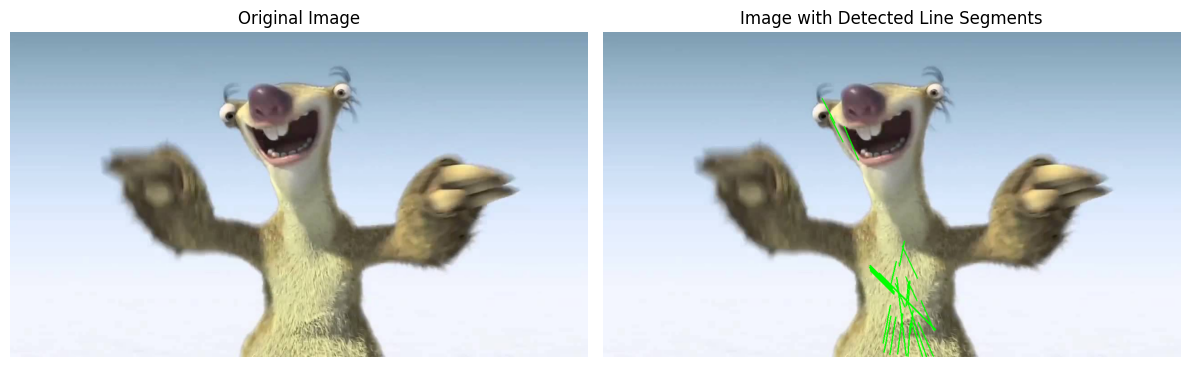

In [35]:
img = cv2.imread('image1.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edges = cv2.Canny(gray_img, 50, 150, apertureSize=3)

rho = 1
theta = np.pi / 180
threshold = 100
minLineLength = 50
maxLineGap = 10

lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]),
                        minLineLength=minLineLength, maxLineGap=maxLineGap)

img_with_lines = img.copy()

if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
plt.title('Image with Detected Line Segments')
plt.axis('off')

plt.tight_layout()
plt.show()

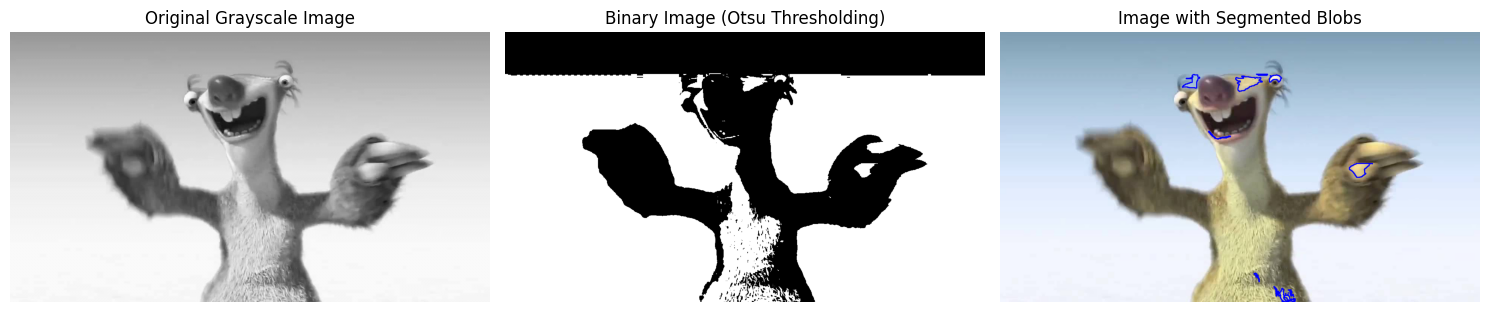

In [36]:
img = cv2.imread('image1.png')

gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

ret, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

contours, hierarchy = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_blob_area = 50
max_blob_area = 5000
filtered_contours = []

for contour in contours:
    area = cv2.contourArea(contour)
    if min_blob_area < area < max_blob_area:
        filtered_contours.append(contour)

img_with_blobs = img.copy()
cv2.drawContours(img_with_blobs, filtered_contours, -1, (255, 0, 0), 2)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(binary_img, cmap='gray')
plt.title('Binary Image (Otsu Thresholding)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(img_with_blobs, cv2.COLOR_BGR2RGB))
plt.title('Image with Segmented Blobs')
plt.axis('off')

plt.tight_layout()
plt.show()